## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn7.ipynb에서 reward를 다르게 디자인해본 버전 (cart의 위치가 중심에 가까울수록 보상을 크게)

In [12]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [13]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [14]:
env = gymnasium.make('CartPole-v1')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q)

In [15]:
lr = 0.0001
discount = 0.99
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [16]:
scores = []
action_count = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    score = 0
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8 * 2
        score += reward
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_values[~batch.terminated] = target_q(batch.next_state[~batch.terminated]).max(1).values
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict()
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    scores.append(score)

    if (i + 1) % 100 == 0:
        print(np.mean(scores[-100:]))

 17%|█▋        | 100/600 [00:06<01:14,  6.74it/s]

17.47025483714026


 33%|███▎      | 200/600 [01:53<11:40,  1.75s/it]

180.21281734295363


 50%|█████     | 300/600 [05:41<13:31,  2.71s/it]

449.1660663608023


 67%|██████▋   | 400/600 [09:32<06:53,  2.07s/it]

498.18561192569


 83%|████████▎ | 500/600 [13:14<03:26,  2.07s/it]

498.45228025146423


100%|██████████| 600/600 [17:03<00:00,  1.71s/it]

498.67899375240484


In [17]:
len(replay_buffer)

10000

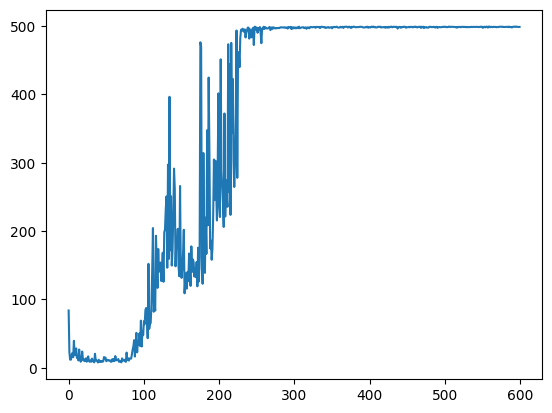

In [18]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [19]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        position = next_state[0]
        distance = abs(position)
        reward -= distance / 4.8 * 2
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[499.33374559137957,
 499.44645107427266,
 499.0761863501254,
 499.46825123214614,
 499.129500587509,
 499.531891962923,
 499.13539763624465,
 498.9456035580339,
 499.25055218958965,
 498.6455361784447]

In [20]:
env.close()

In [21]:
env = gymnasium.make('CartPole-v1')